ECML-PKDD 2020 Hands-on Tutorial

*What and How of Machine Learning Transparency*:  
Building Bespoke Explainability Tools with Interoperable Algorithmic Components

<https://events.fat-forensics.org/2020_ecml-pkdd/>

Authors: Kacper Sokol <k.sokol@bristol.ac.uk> and
         Alex Hepburn <ah13558@bristol.ac.uk>  
Licence: new BSD

---

---

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fat-forensics/events/blob/master/)
[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/fat-forensics/events/master)

First, we need to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
LIBRARY_URL = ('https://raw.githubusercontent.com/fat-forensics/events/master/'
               'resources/2020_ecml-pkdd/notebooks/fatf_ecml.py')

try:
    import google.colab
    !wget $LIBRARY_URL -O fatf_ecml.py
except ImportError:
    pass

import fatf_ecml

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display

%matplotlib inline

In [4]:
fatf_ecml.initialise_colab()

Not in Colab; nothing to do.


# Testing the Tutorial Environment #
This notebook is a pruned version of
"[how to build LIME yourself](https://fat-forensics.org/how_to/transparency/tabular-surrogates.html)"
*How-To Guide* taken from the FAT Forensics
[documentation](https://fat-forensics.org/).

Regardless of whether you are using *Colab*, *Binder* or running the tutorial
materials directly on your personal computer, you should execute this notebook
to check whether everything functions correctly.

We will discuss all of these steps in more detail during the hands-on session
in Part 3 of the tutorial.

> **For now, you do not need to worry about the meaning of any of these.**
  **Just make sure it runs.**


First, let's set up required packages and fix the random seed for
reproducibility.

In [5]:
import fatf

import numpy as np

In [6]:
fatf.setup_random_seed(42)

20-Sep-01 15:42:34 fatf         INFO     Seeding RNGs using the input parameter.
20-Sep-01 15:42:34 fatf         INFO     Seeding RNGs with 42.


## Data and Black Box ##

Let's get the beloved *iris* data set.

In [7]:
import fatf.utils.data.datasets as fatf_datasets

iris_data_dict = fatf_datasets.load_iris()
iris_data = iris_data_dict['data']
iris_target = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_target_names = iris_data_dict['target_names'].tolist()

Let's get our black box -- a k-nearest neighbours classifier.

In [8]:
import fatf.utils.models.models as fatf_models

blackbox_model = fatf_models.KNN(k=3)
blackbox_model.fit(iris_data, iris_target)

20-Sep-01 15:43:03 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


And check its accuracy.

In [9]:
import sklearn.metrics

predictions = blackbox_model.predict(iris_data)
sklearn.metrics.accuracy_score(iris_target, predictions)

0.96

Now, let's choose a data point to be explained.

In [10]:
data_point = iris_data[0]
print('Data point:')
display(data_point)

data_point_probabilities = blackbox_model.predict_proba(
    data_point.reshape(1, -1))[0]
print('\nClass probabilities:')
display(data_point_probabilities)

data_point_prediction = data_point_probabilities.argmax(axis=0)
print('\nClass prediction:')
display(data_point_prediction)

data_point_class = iris_target_names[data_point_prediction]
print('\nPredicted class name:')
display(data_point_class)

Data point:


array([5.1, 3.5, 1.4, 0.2], dtype=float32)


Class probabilities:


array([1., 0., 0.])


Class prediction:


0


Predicted class name:


'setosa'

Let's visualise the selected instance using two of the features.

Selected features:


['petal length (cm)', 'petal width (cm)']

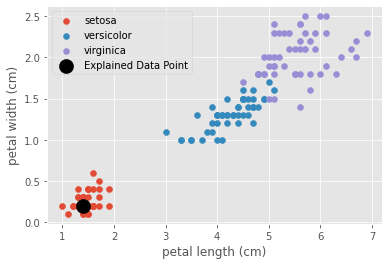

In [11]:
import matplotlib.pyplot as plt

print('Selected features:')
display(iris_feature_names[2:])

data_figure = plt.figure()
plt.scatter(iris_data[1:50, 2], iris_data[1:50, 3],
            label=iris_target_names[0])
plt.scatter(iris_data[50:100, 2], iris_data[50:100, 3],
            label=iris_target_names[1])
plt.scatter(iris_data[100:150, 2], iris_data[100:150, 3],
            label=iris_target_names[2])
plt.scatter(data_point[2], data_point[3],
            label='Explained Data Point', s=200, c='k')

plt.xlabel(iris_feature_names[2])
plt.ylabel(iris_feature_names[3])
plt.legend()

## Data Augmentation ##

Next, let's sample some data in the neighbourhood of the explained instance.

In [12]:
import fatf.utils.data.augmentation as fatf_augmentation

augmenter = fatf_augmentation.Mixup(iris_data, ground_truth=iris_target)

In [13]:
sampled_data = augmenter.sample(data_point, samples_number=50)
sampled_data_probabilities = blackbox_model.predict_proba(sampled_data)

sampled_data_predictions = sampled_data_probabilities.argmax(axis=1)

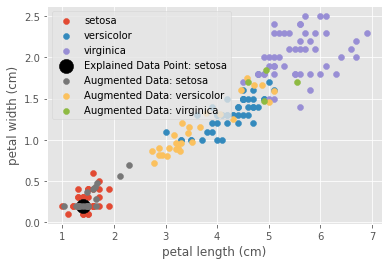

In [14]:
sampled_data_0_indices = np.where(sampled_data_predictions == 0)[0]
sampled_data_1_indices = np.where(sampled_data_predictions == 1)[0]
sampled_data_2_indices = np.where(sampled_data_predictions == 2)[0]

plt.figure()
plt.scatter(iris_data[1:50, 2], iris_data[1:50, 3],
            label=iris_target_names[0])
plt.scatter(iris_data[50:100, 2], iris_data[50:100, 3],
            label=iris_target_names[1])
plt.scatter(iris_data[100:150, 2], iris_data[100:150, 3],
            label=iris_target_names[2])
plt.scatter(data_point[2], data_point[3],
            label='Explained Data Point: {}'.format(data_point_class),
            s=200, c='k')

plt.scatter(sampled_data[sampled_data_0_indices, 2],
            sampled_data[sampled_data_0_indices, 3],
            label='Augmented Data: {}'.format(iris_target_names[0]))
plt.scatter(sampled_data[sampled_data_1_indices, 2],
            sampled_data[sampled_data_1_indices, 3],
            label='Augmented Data: {}'.format(iris_target_names[1]))
plt.scatter(sampled_data[sampled_data_2_indices, 2],
            sampled_data[sampled_data_2_indices, 3],
            label='Augmented Data: {}'.format(iris_target_names[2]))

plt.xlabel(iris_feature_names[2])
plt.ylabel(iris_feature_names[3])
plt.legend()

## Interpretable Representation ##

Now, let's generate an interpretable representation.

In [15]:
import fatf.utils.data.discretisation as fatf_discretisation

discretiser = fatf_discretisation.QuartileDiscretiser(
    iris_data, feature_names=iris_feature_names)

In [16]:
data_point_discretised = discretiser.discretise(data_point)
sampled_data_discretised = discretiser.discretise(sampled_data)

In [17]:
import fatf.utils.data.transformation as fatf_transformation

sampled_data_binarised = fatf_transformation.dataset_row_masking(
    sampled_data_discretised, data_point_discretised)

data_point_binarised = fatf_transformation.dataset_row_masking(
    data_point_discretised.reshape(1, -1), data_point_discretised)

In [18]:
print('The explained instance in the discrete representation:')
display(data_point_discretised)

print('\nThe explained instance in the binary interpretable representation:')
display(data_point_binarised)

print('\n{}\n'.format(40*'~+'))

print('A sampled data point in the discrete representation:')
display(sampled_data_discretised[0, :])

print('\nThe same sampled data point in the '
      'binary interpretable representation:')
display(sampled_data_binarised[0, :])

The explained instance in the discrete representation:


array([0, 3, 0, 0], dtype=int8)


The explained instance in the binary interpretable representation:


array([[1, 1, 1, 1]], dtype=int8)


~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+

A sampled data point in the discrete representation:


array([1, 3, 0, 0], dtype=int8)


The same sampled data point in the binary interpretable representation:


array([0, 1, 1, 1], dtype=int8)

## Explanation Generation ##

Finally, we fit a local surrogate model and generate the explanation.

We start by weighting the data to enforce locality of the explanation
even more.

In [19]:
import fatf.utils.distances as fatf_distances
import fatf.utils.kernels as fatf_kernels

features_number = sampled_data_binarised.shape[1]
kernel_width = np.sqrt(features_number) * 0.75

distances = fatf_distances.euclidean_point_distance(
    np.ones(features_number), sampled_data_binarised)
weights = fatf_kernels.exponential_kernel(
    distances, width=kernel_width)

We will explain the class predicted by the black box for the
selected instance.

In [20]:
explained_class_name = 'setosa'

explained_class_index = iris_target_names.index(explained_class_name)

print('{}: {}'.format(explained_class_index, explained_class_name))

0: setosa


In [21]:
sampled_data_predictions_setosa = (
    sampled_data_probabilities[:, explained_class_index])

Let's introduce some sparsity to the explanation and select just *two* of
the **interpretable** features.

In [22]:
import fatf.utils.data.feature_selection.sklearn as fatf_feature_ssk

lasso_indices = fatf_feature_ssk.lasso_path(
    sampled_data_binarised, sampled_data_predictions_setosa, weights, 2)

sampled_data_binarised_2f = sampled_data_binarised[:, lasso_indices]

In [23]:
interpretable_feature_names = []
for feature_index in lasso_indices:
    bin_id = data_point_discretised[feature_index].astype(int)
    interpretable_feature_name = (
        discretiser.feature_value_names[feature_index][bin_id])
    interpretable_feature_names.append(interpretable_feature_name)

interpretable_feature_names

['*petal length (cm)* <= 1.60', '*petal width (cm)* <= 0.30']

Last but not least, we will fit a local surrogate *linear* model and generate the explanation.

In [24]:
import sklearn.linear_model

lime = sklearn.linear_model.Ridge()

In [25]:
lime.fit(
    sampled_data_binarised_2f,
    sampled_data_predictions_setosa,
    sample_weight=weights)

Ridge()

*setosa* class (0) explanation (importance given in brackets):
    ->*petal length (cm)* <= 1.60<-: 0.4297609038698995
    ->*petal width (cm)* <= 0.30<-: 0.37901863586706086

(Data visualisation re-plotted for convenience.)


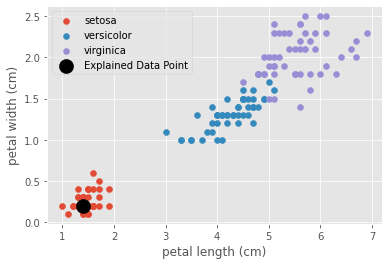

In [26]:
print('*{}* class ({}) explanation (importance given in brackets):'.format(
    explained_class_name, explained_class_index))
for name, importance in zip(interpretable_feature_names, lime.coef_):
    print('    ->{}<-: {}'.format(name, importance))

print('\n(Data visualisation re-plotted for convenience.)')
data_figure

## That's It ##

Your environment works and you are ready for Part 3 of the tutorial.

> You can experiment with this notebook during the break.
  Consult the
  "[how to build LIME yourself](https://fat-forensics.org/how_to/transparency/tabular-surrogates.html)"
  *How-To Guide* distributed with the FAT Forensics
  [documentation](https://fat-forensics.org/) for more details.